In [4]:
import os
import sys
import matplotlib.pyplot as plt
import matplotlib.colors
import numpy as np
import geopandas as gpd
import seaborn as sns
from HierarchicalGeoClustering import TreeClusters, Clustering 
import shapely 
from matplotlib import cm
import pandas as pd
import warnings
import hdbscan
import pickle5 as pickle
warnings.filterwarnings('ignore')

In [5]:
tree_create = TreeClusters.TreeClusters()
tree_create.root = TreeClusters.NodeCluster(name='root')
tree_create.levels_nodes.append( [tree_create.root])
##level 1
TreeClusters.NodeCluster(name='l1_c0',parent= tree_create.root)
# TreeClusters.NodeCluster(name='l1_c1',parent= tree_create.root)
# TreeClusters.NodeCluster(name='l1_c2',parent= tree_create.root)
tree_create.levels_nodes.append([i for i in tree_create.root.children])
##Level 2
TreeClusters.NodeCluster(name=tree_create.root.children[0].name + '_l2_c0',parent= tree_create.root.children[0])
TreeClusters.NodeCluster(name=tree_create.root.children[0].name + '_l2_c1',parent= tree_create.root.children[0])
# TreeClusters.NodeCluster(name=tree_create.root.children[1].name + '_l2_c0',parent= tree_create.root.children[1])
# TreeClusters.NodeCluster(name=tree_create.root.children[2].name + '_l2_c1',parent= tree_create.root.children[2])
# TreeClusters.NodeCluster(name=tree_create.root.children[2].name + '_l2_c2',parent= tree_create.root.children[2])
tree_create.levels_nodes.append([j for i in tree_create.root.children for j in i.children])
##level 3 
level_2 = tree_create.get_level(2)
l_3_0 = TreeClusters.NodeCluster(name= level_2[0].name + '_l3_c0',parent= level_2[0])
l_3_1 =TreeClusters.NodeCluster(name= level_2[0].name + '_l3_c1',parent= level_2[0])
l_3_2 =TreeClusters.NodeCluster(name= level_2[1].name  + '_l3_c0',parent= level_2[1])
tree_create.levels_nodes.append([l_3_0, l_3_1, l_3_2])

tree_create.print_structure()

root
root    
└── l1_c0
    ├── l1_c0_l2_c0
    │   ├── l1_c0_l2_c0_l3_c0
    │   └── l1_c0_l2_c0_l3_c1
    └── l1_c0_l2_c1
        └── l1_c0_l2_c1_l3_c0


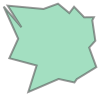

In [6]:
tree_create.root.polygon_cluster = tree_create.root.create_polygon(from_points_num=40)
tree_create.root.point_cluster_noise = tree_create.root.create_random_points(80)
tree_create.root.polygon_cluster

In [7]:
tree_create.levels_nodes

[[<HierarchicalGeoClustering.TreeClusters.NodeCluster at 0x7efdc2e41890>],

In [8]:
level_1=tree_create.get_level(1)
count = 0
for node in level_1 :
    # poly_child = tree_create.root.polygon_not_inter
    print(node.name )
    polygon_child , center_child = node.parent.polygon_not_intersec_children(random_state = count*24+3) 
    node.polygon_cluster = polygon_child
    node.center = center_child
    node.point_cluster_noise = node.create_random_points(60)
    count +=5

l1_c0


In [9]:
level2=tree_create.get_level(2)
count = 0
for node in level2 :
    # poly_child = tree_create.root.polygon_not_inter
    print(node.name )
    polygon_child , center_child = node.parent.polygon_not_intersec_children(random_state = count*24+3) 
    node.polygon_cluster = polygon_child
    node.center = center_child
    node.point_cluster_noise = node.create_random_points(40)
    count +=5

l1_c0_l2_c0
l1_c0_l2_c1


In [10]:
level3 = tree_create.get_level(3)
count = 0
for node in level3 :
    # poly_child = tree_create.root.polygon_not_inter
    print( node.name )
    polygon_child , center_child = node.parent.polygon_not_intersec_children(random_state = count*24+19, verbose = True) 
    node.polygon_cluster = polygon_child
    node.center = center_child
    node.point_cluster_noise = node.create_random_points(20)
    count += 5

l1_c0_l2_c0_l3_c0
l1_c0_l2_c0_l3_c1
l1_c0_l2_c1_l3_c0


(-0.04007007305850546,
 1.0218020164410249,
 -0.02109604495381983,
 0.9914107666998462)

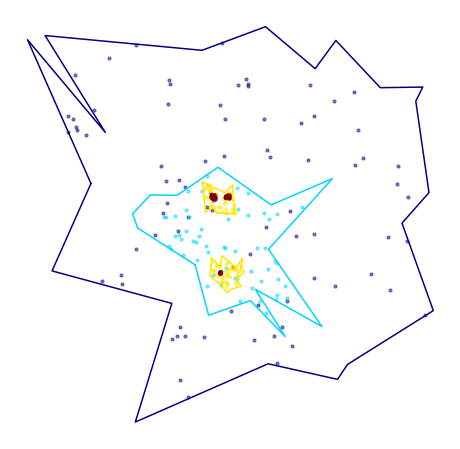

In [97]:
fig, axs = plt.subplots( figsize=(8,8))
tree_create.visualize(axs, size_cluster=10 , polygon=True)
axs.axis('off')

In [13]:
def node_translate(node, x_off, y_off, a=1, b=0, d=0,e=1):
    """
    Translate the node and ite point and there children
    """
    point_trans_x= x_off
    point_trans_y= y_off
    matrix_trans = [a, b ,d, e, point_trans_x, point_trans_y]
    new_points= [shapely.affinity.affine_transform(i,matrix_trans) for i in node.point_cluster_noise  ]
    node.point_cluster_noise = new_points           
    
    node.polygon_cluster = shapely.affinity.affine_transform(node.polygon_cluster,
                                                    matrix_trans
                                                    )
    if node.center != None:
        node.center = shapely.affinity.affine_transform(node.center,
                                                         matrix_trans
                                                        )
    for i in node.children:
        node_translate(i, x_off, y_off, a=a, b= b, d=d,e=e)
    
    return

In [87]:
level_3=tree_create.get_level(3)
for i in level_3:
    print(i.parent.name)
# node_translate(level_2[1], -0.06,- 0.06,  a= 1.0, b=0,d=0, e= 1.0 )

l1_c0_l2_c0
l1_c0_l2_c0
l1_c0_l2_c1


In [96]:
# node_translate(level_3[0], -0.005, 0.0,  a= 1.0, b=0,d=0, e= 1.0 )

In [98]:
def get_geopandas_tree_polygon(tree_geo):
    """
    Create a geopandas with the polygons from the tree
    """
    list_dic=[]
    for i , level_nodes in enumerate(tree_geo.levels_nodes):
        # levels_nodes= tree_geo.get_level(i)
        # print(level_nodes)
        for node in level_nodes:
            
            if node.parent == None:
                parent = ''
            else:
                parent = node.parent.name
            list_dic.append({'Polygon': node.polygon_cluster,
                             'name': node.name,
                             'level': i,
                             'parent': parent})
    return gpd.GeoDataFrame(list_dic)

In [99]:
df_polygons_tree= get_geopandas_tree_polygon(tree_create)

In [5]:
# df_polygons_tree.to_pickle('../output/toy_gep.pickle')
with open("../output/toy_gep.pickle", "rb") as fh:
    df_polygons_tree = pickle.load(fh)
df_polygons_tree.head()

,Polygon,name,level,parent
0,POLYGON ((0.1591601996929714 0.580298990728507...,root,0,
1,POLYGON ((0.4071121551098488 0.390763274864394...,l1_c0,1,root
2,POLYGON ((0.4314899945789328 0.513441916759204...,l1_c0_l2_c0,2,l1_c0
3,POLYGON ((0.4448622423232922 0.389205405282803...,l1_c0_l2_c1,2,l1_c0
4,POLYGON ((0.4449054440526734 0.545459339707125...,l1_c0_l2_c0_l3_c0,3,l1_c0_l2_c0


In [6]:
def tree_from_df(df_poligons):
    """
    Recreate a tree from the polygons returning a tree structure
    """
    tree_c = TreeClusters.TreeClusters()
    
    for level in df_poligons.level.unique():
        level_nodes = []
        for row, polygon_node in df_poligons[df_poligons['level']==level].iterrows():
            node = TreeClusters.NodeCluster(name=polygon_node['name'])
            if polygon_node['parent']  != '':
                parents = tree_c.get_level(level-1)
                parents_goo = [pa for pa in parents if pa.name == polygon_node['parent']]
                node.parent = parents_goo[0]
            node.polygon_cluster = polygon_node['Polygon']

            level_nodes.append(node)
        tree_c.levels_nodes.append(level_nodes)
    tree_c.root = tree_c.get_level(0)[0]
    return tree_c
                

In [246]:
tree_v = tree_from_df(df_polygons_tree)

In [334]:
### Añadirle puntos
count = 0
for level in tree_v.levels_nodes:
    for node in level:
        rand_points  = node.create_random_points(30-3*count, random_state=127 )
        for node_child in node.children:
            rand_points= [po for po in rand_points if node_child.polygon_cluster.contains(po) != True ]  
        node.point_cluster_noise = shapely.geometry.MultiPoint(rand_points)
    count +=1

(-0.04007007305850546,
 1.0218020164410249,
 -0.02109604495381983,
 0.9914107666998462)

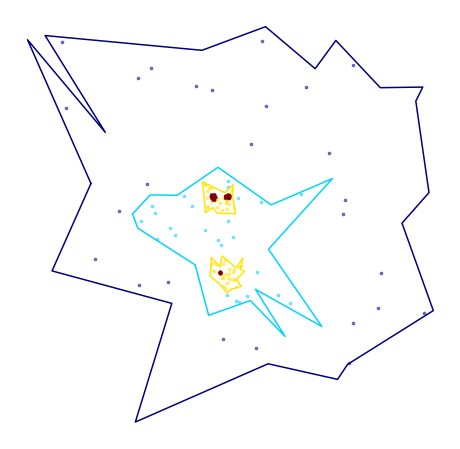

In [335]:
fig, axs = plt.subplots( figsize=(8,8))
tree_v.visualize(axs, size_cluster=7 , polygon=True)
axs.axis('off')

In [336]:
tree_v_points= tree_v.get_points_tree()
X_2=np.array([[p.x,p.y] for p in tree_v_points])
dic_points={'points':[X_2], 'parent':''}

In [337]:
tree_adaptative= Clustering.recursive_clustering_tree(
                        dic_points,
                        levels_clustering = 3,
                        algorithm = 'adaptative_DBSCAN'
                )

The min_k value is too large for the number of points returns empty clusters
The min_k value is too large for the number of points returns empty clusters
The min_k value is too large for the number of points returns empty clusters


In [338]:
tree_OPTICS= Clustering.recursive_clustering_tree(
                        dic_points,
                        levels_clustering = 3,
                        algorithm = 'optics'
                )

In [339]:
tree_HDBSCAN = Clustering.recursive_clustering_tree(
                        dic_points,
                        levels_clustering = 3,
                        algorithm = 'hdbscan'
                )

(0.04700085713724978,
 0.9940080286431606,
 0.12587327355705527,
 0.9488828520848022)

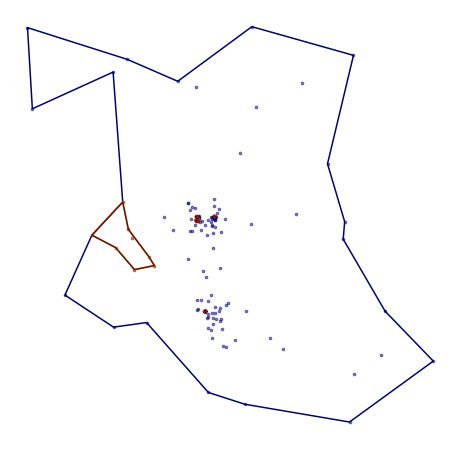

In [340]:
fig, axs = plt.subplots( figsize=(8,8))
tree_OPTICS.visualize(axs, size_cluster=7 , polygon=True)
axs.axis('off')

(0.04700085713724978,
 0.9940080286431606,
 0.12587327355705527,
 0.9488828520848022)

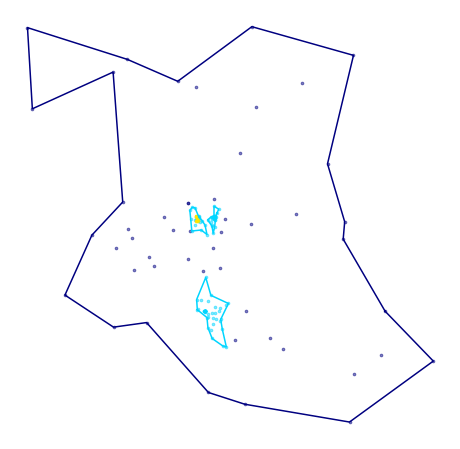

In [341]:
fig, axs = plt.subplots( figsize=(8,8))
tree_HDBSCAN.visualize(axs, size_cluster=7 , polygon=True)
axs.axis('off')

(0.04700085713724978,
 0.9940080286431606,
 0.12587327355705527,
 0.9488828520848022)

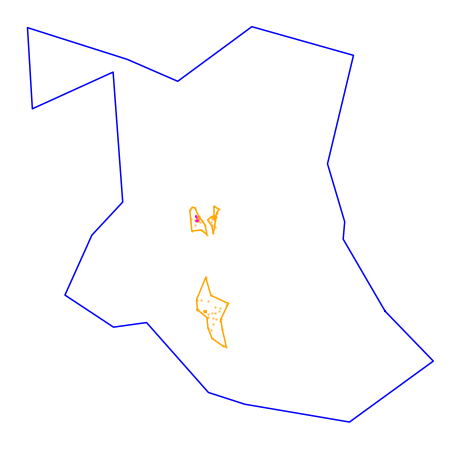

In [342]:
fig, axs = plt.subplots( figsize=(8,8))
# tree_HDBSCAN.visualize(axs, size_cluster=7 , polygon=True)
tree_HDBSCAN.root.viewer_cluster(axs ,
                                 color_cluster = 'white',
                                 polygon = True, 
                                polygon_color = 'blue')
for node in tree_HDBSCAN.get_level(1):
    node.viewer_cluster(axs, polygon=True, polygon_color= 'orange')

for node in tree_HDBSCAN.get_level(2):
    node.viewer_cluster(axs, polygon=True, polygon_color= 'magenta')
    


axs.axis('off')

In [343]:
clusterer = hdbscan.HDBSCAN(min_cluster_size=5, gen_min_span_tree=True, leaf_size=40,metric='euclidean', )
clusterer.fit(X_2)


# hdbscan.HDBSCAN  dic_points

HDBSCAN(gen_min_span_tree=True)

<AxesSubplot:>

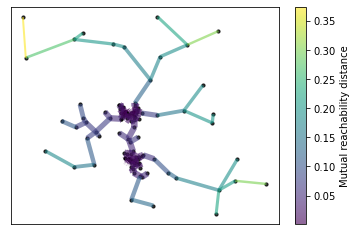

In [344]:
clusterer.minimum_spanning_tree_.plot(edge_cmap='viridis',
                                      edge_alpha=0.6,
                                      node_size=10,
                                      edge_linewidth=2)

<AxesSubplot:ylabel='distance'>

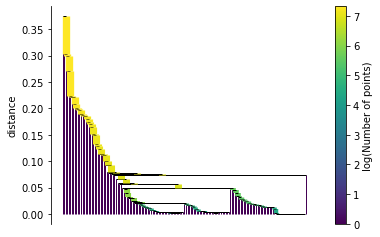

In [345]:
clusterer.single_linkage_tree_.plot(cmap='viridis', colorbar=True)

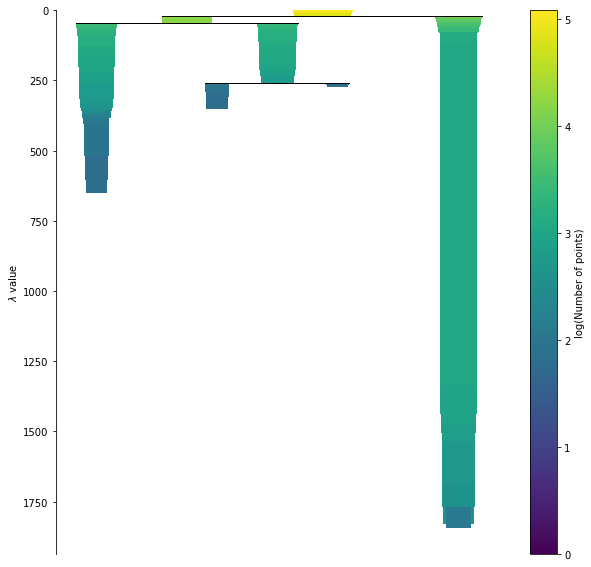

In [346]:
fig, axs = plt.subplots( figsize=(10,10))

axs = clusterer.condensed_tree_.plot(axis= axs ,
                                     log_size=True,
                                     leaf_separation = 2,
                                     select_clusters=False,
                                     max_rectangles_per_icicle= 25)

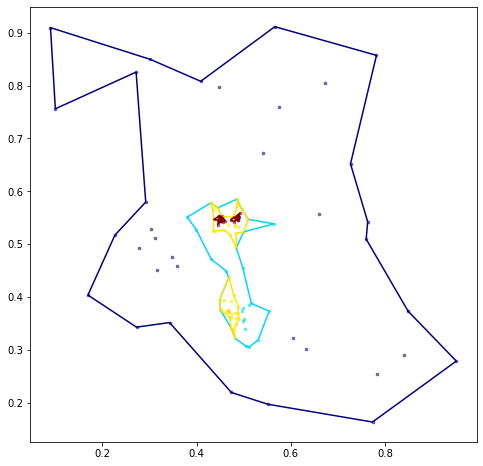

In [347]:
fig, axs = plt.subplots( figsize=(8,8))
tree_adaptative.visualize(axs, size_cluster=7, polygon=True)

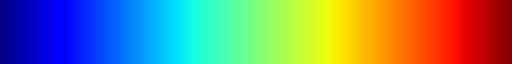

In [348]:
jet

In [349]:
jet =  plt.get_cmap('jet')



In [350]:
len(tree_v.levels_nodes)

4

In [351]:
colors(0)

TypeError: 'ScalarMappable' object is not callable

In [359]:
all_noise= [p for p in node_root.point_cluster_noise]
children_noise = [ p for child in node_root.children for p in all_noise if child.polygon_cluster.contains(p) ]


[]

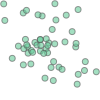

In [366]:
node_root_hbscan.point_cluster_noise

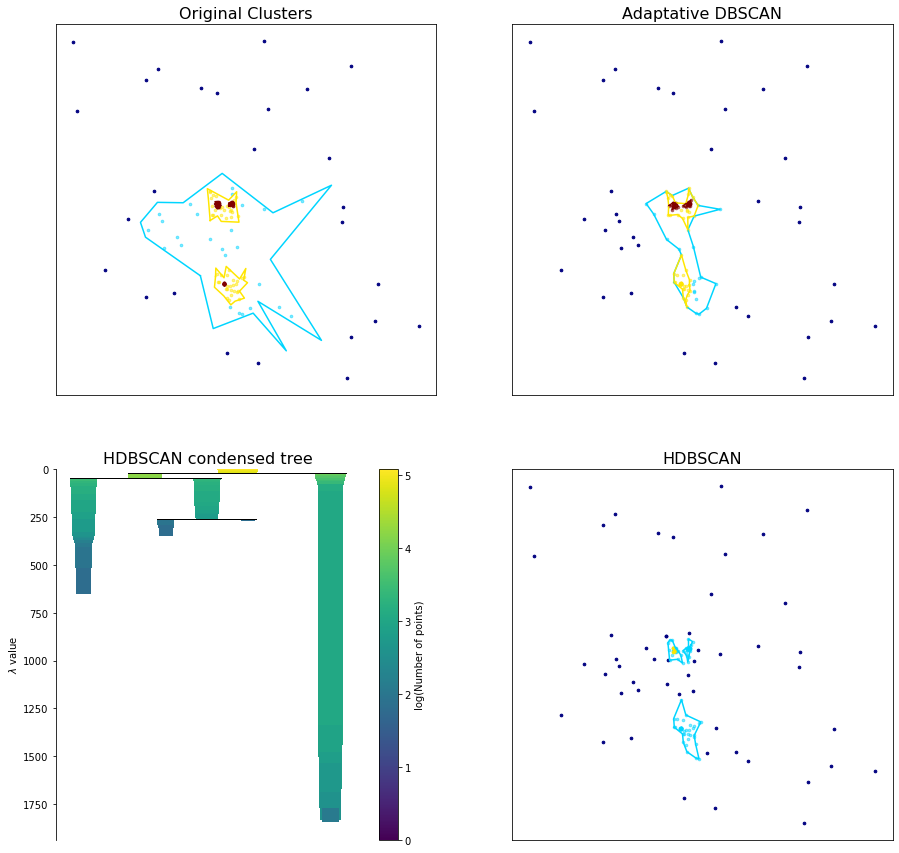

In [369]:
fig, axs = plt.subplots(2,2, figsize=(15,15))
axs = axs.ravel()

jet =  plt.get_cmap('jet')
norm = matplotlib.colors.Normalize(vmin=0, vmax=3)
colors= cm.ScalarMappable(norm=norm, cmap=jet)

node_root= tree_v.root

x_root = [p.x for p in node_root.point_cluster_noise] 
y_root = [p.y for p in node_root.point_cluster_noise] 


axs[0].scatter(x_root, y_root, s=7, color = colors.to_rgba(0))

for i in tree_v.get_level(1):
    i.viewer_cluster(axs[0],
                   color_cluster= colors.to_rgba(1),
                   size_cluster=7,
                   polygon_color= colors.to_rgba(1),
                   polygon=True
                  )
    
for i in tree_v.get_level(2):
    i.viewer_cluster(axs[0],
                   color_cluster= colors.to_rgba(2),
                   size_cluster=7,
                   polygon_color= colors.to_rgba(2),
                   polygon=True
                  )

for i in tree_v.get_level(3):
    i.viewer_cluster(axs[0],
                   color_cluster= colors.to_rgba(3),
                   size_cluster=7,
                   polygon_color= colors.to_rgba(3),
                   polygon=True
                  )

# tree_v.visualize(axs[0], levels=[1,2,3],  size_cluster=7 )

axs[0].xaxis.set_ticklabels([])
axs[0].xaxis.set_ticks([])
axs[0].yaxis.set_ticklabels([])
axs[0].yaxis.set_ticks([])
axs[0].title.set_size(16)
axs[0].title.set_text('Original Clusters')


node_root_adap = tree_adaptative.root
x_root_adap = [p.x for p in node_root_adap.point_cluster_noise] 
y_root_adap = [p.y for p in node_root_adap.point_cluster_noise] 
axs[1].scatter(x_root_adap, y_root_adap, s=7, color = colors.to_rgba(0))
for i in tree_adaptative.get_level(1):
    i.viewer_cluster(axs[1],
                   color_cluster= colors.to_rgba(1),
                   size_cluster=7,
                   polygon_color= colors.to_rgba(1),
                   polygon=True
                  )
    
for i in tree_adaptative.get_level(2):
    i.viewer_cluster(axs[1],
                   color_cluster= colors.to_rgba(2),
                   size_cluster=7,
                   polygon_color= colors.to_rgba(2),
                   polygon=True
                  )

for i in tree_adaptative.get_level(3):
    i.viewer_cluster(axs[1],
                   color_cluster= colors.to_rgba(3),
                   size_cluster=7,
                   polygon_color= colors.to_rgba(3),
                   polygon=True
                  )

# tree_adaptative.visualize(axs[1],size_cluster=7, polygon=True)
axs[1].title.set_size(16)
axs[1].title.set_text('Adaptative DBSCAN')
axs[1].xaxis.set_ticklabels([])
axs[1].xaxis.set_ticks([])
axs[1].yaxis.set_ticklabels([])
axs[1].yaxis.set_ticks([])
clusterer.condensed_tree_.plot(axis= axs[2] ,
                                     log_size=True,
                                     leaf_separation = 2,
                                     select_clusters=False,
                                     max_rectangles_per_icicle= 25)


axs[2].title.set_size(16)
axs[2].title.set_text('HDBSCAN condensed tree')

###### HDBSCAN
node_root_hbscan = tree_HDBSCAN.root
x_root_hdbscan = [p.x for p in node_root_hbscan.point_cluster_noise] 
y_root_hdbscan = [p.y for p in node_root_hbscan.point_cluster_noise]
axs[3].scatter(x_root_hdbscan, y_root_hdbscan, s=7, color = colors.to_rgba(0))

for i in tree_HDBSCAN.get_level(1):
    i.viewer_cluster(axs[3],
                   color_cluster= colors.to_rgba(1),
                   size_cluster=7,
                   polygon_color= colors.to_rgba(1),
                   polygon=True
                  )
    
for i in tree_HDBSCAN.get_level(2):
    i.viewer_cluster(axs[3],
                   color_cluster= colors.to_rgba(2),
                   size_cluster=7,
                   polygon_color= colors.to_rgba(2),
                   polygon=True
                  )

for i in tree_HDBSCAN.get_level(3):
    i.viewer_cluster(axs[3],
                   color_cluster= colors.to_rgba(3),
                   size_cluster=7,
                   polygon_color= colors.to_rgba(3),
                   polygon=True
                  )

# tree_HDBSCAN.visualize(axs[3],size_cluster=7, polygon=True)

axs[3].xaxis.set_ticklabels([])
axs[3].xaxis.set_ticks([])
axs[3].yaxis.set_ticklabels([])
axs[3].yaxis.set_ticks([])
axs[3].title.set_size(16)
axs[3].title.set_text('HDBSCAN')
# fig.savefig('../output/toy_data.png', dpi=600)
fig.savefig('../output/toy_data.pdf', dpi=600)

In [356]:
plot_data = clusterer.condensed_tree_.get_plot_data(leaf_separation=1,
                                       log_size=True,
                                       max_rectangle_per_icicle=14)


In [87]:
clusterer.condensed_tree_._raw_tree

array([(268,  17,    2.65135369,   1), (268,  23,    3.1415117 ,   1),
       (268,  47,    3.97877338,   1), (268,   4,    4.37550452,   1),
       (268,  52,    4.72158284,   1), (268,  25,    4.91782526,   1),
       (268,  29,    5.08808267,   1), (268,  12,    5.76885337,   1),
       (268,  31,    5.94436236,   1), (268,  38,    6.02297305,   1),
       (268,  43,    6.80825791,   1), (268,  49,    7.13359975,   1),
       (268,  35,    7.57418132,   1), (268,   0,    7.75163468,   1),
       (268,  24,    7.76098393,   1), (268,   2,    7.76098393,   1),
       (268, 269,    8.40968652,   7), (268, 270,    8.40968652, 245),
       (269,  45,    8.40968652,   1), (270,  10,    8.67880525,   1),
       (269,  46,    8.82990335,   1), (270,  96,    9.68969279,   1),
       (269,   7,    8.97062173,   1), (269,  30,    8.97062173,   1),
       (269,  27,    8.97062173,   1), (269,  14,    8.97062173,   1),
       (269,   1,    8.97062173,   1), (270,  36,    9.78251332,   1),
      

In [88]:
HDBSCAN(algorithm='best', alpha=1.0, approx_min_span_tree=True,
    gen_min_span_tree=True, leaf_size=40, memory=Memory(cachedir=None),
    metric='euclidean', min_cluster_size=5, min_samples=None, p=None)

NameError: name 'HDBSCAN' is not defined